In [85]:
# import statments
import pandas as pd
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
from collections import defaultdict

In [86]:
#global variables
renamed_stocks = {"FB": "META"}
failed_downloads = []
cutoff_date = pd.to_datetime('2017-01-01')

#Clean dataframe
df = pd.read_csv("congress_trades.csv")

df["ReportDate"] = pd.to_datetime(df["ReportDate"])
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"])

df = df.loc[df["TransactionDate"] > cutoff_date]
df.loc[~df["Transaction"].str.contains("Purchase"), "Amount"] = - df["Amount"]
df["Ticker"] = df["Ticker"].replace(renamed_stocks)

df.sort_values("TransactionDate", ascending=True, inplace=True)

In [87]:
#partition dataframe
portfolio = df.loc[(df["Representative"] == "Bill Flores")]
portfolio.head(3)

,Representative,ReportDate,TransactionDate,Ticker,Transaction,Range,House,Amount,Party,last_modified
35034,Bill Flores,2017-02-13,2017-01-13,OKE,Purchase,"$15,001 - $50,000",Representatives,15001.0,R,2023-11-16
35036,Bill Flores,2017-02-13,2017-01-13,WMB,Sale,"$100,001 - $250,000",Representatives,-100001.0,R,2023-11-16
35038,Bill Flores,2017-02-13,2017-01-13,ETE,Purchase,"$1,001 - $15,000",Representatives,1001.0,R,2023-11-16


In [88]:
#Download and store SPY stock data
end_date = datetime.today().strftime('%Y-%m-%d')
stock_data = yf.download("SPY", start=cutoff_date, end=end_date, auto_adjust=True, rounding=True, progress=False) #maybe use back_adjust=True? dunno
stock_data["Ticker"] = "SPY"
stock_data = stock_data[["Ticker", "Close"]]
stock_data

,Ticker,Close
Date,,
2017-01-03,SPY,198.56
2017-01-04,SPY,199.74
2017-01-05,SPY,199.58
2017-01-06,SPY,200.30
2017-01-09,SPY,199.64
...,...,...
2024-09-05,SPY,549.61
2024-09-06,SPY,540.36
2024-09-09,SPY,546.41


In [89]:
#Download and store AAPL and DIS stock data
tickers = portfolio["Ticker"].unique().tolist()
stocks = yf.download(tickers, start=cutoff_date, end=end_date, auto_adjust=True, rounding=True, progress=False)
stocks_close = stocks['Close']
formatted_stocks = stocks_close.reset_index().melt(id_vars=['Date'], var_name='Ticker', value_name='Close')
formatted_stocks = formatted_stocks.dropna(subset=['Close'])
formatted_stocks.set_index("Date", inplace=True)
stock_data = pd.concat([stock_data, formatted_stocks])
stock_data = stock_data.sort_values(by=['Ticker', 'Date'])
stock_data["DailyROI"] = stock_data.groupby('Ticker')['Close'].pct_change().fillna(0) + 1.0
stock_data

$TEGP: possibly delisted; No price data found  (1d 2017-01-01 00:00:00 -> 2024-09-12)
$COH: possibly delisted; No price data found  (1d 2017-01-01 00:00:00 -> 2024-09-12)
$II: possibly delisted; No price data found  (1d 2017-01-01 00:00:00 -> 2024-09-12)
$SXL: possibly delisted; No price data found  (1d 2017-01-01 00:00:00 -> 2024-09-12)
$TLLP: possibly delisted; No price data found  (1d 2017-01-01 00:00:00 -> 2024-09-12)



17 Failed downloads:
['SC', 'WGP', 'BPMP', 'EQM', 'ANDX', 'PSXP', 'SHLX', 'NBLX', 'TGE', 'SPN', 'SEMG', 'LM']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
['TEGP', 'COH', 'II', 'SXL', 'TLLP']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-01-01 00:00:00 -> 2024-09-12)')


,Ticker,Close,DailyROI
Date,,,
2017-01-03,AAPL,26.92,1.000000
2017-01-04,AAPL,26.89,0.998886
2017-01-05,AAPL,27.03,1.005206
2017-01-06,AAPL,27.33,1.011099
2017-01-09,AAPL,27.58,1.009147
...,...,...,...
2024-09-05,XOM,113.17,0.992197
2024-09-06,XOM,112.64,0.995317
2024-09-09,XOM,115.01,1.021040


In [90]:
#reset index for merging
stock_data.reset_index(inplace=True)

In [91]:
#add price and stock amount data for each transaction
portfolio = portfolio.merge(stock_data, how='left', left_on=['TransactionDate', 'Ticker'], right_on=['Date', 'Ticker'])
portfolio.drop(columns=['Date', "DailyROI"], inplace=True)
portfolio["StockAmount"] = portfolio["Amount"]/portfolio["Close"]
portfolio.head()

,Representative,ReportDate,TransactionDate,Ticker,Transaction,Range,House,Amount,Party,last_modified,Close,StockAmount
0,Bill Flores,2017-02-13,2017-01-13,OKE,Purchase,"$15,001 - $50,000",Representatives,15001.0,R,2023-11-16,34.41,435.948852
1,Bill Flores,2017-02-13,2017-01-13,WMB,Sale,"$100,001 - $250,000",Representatives,-100001.0,R,2023-11-16,18.62,-5370.622986
2,Bill Flores,2017-02-13,2017-01-13,ETE,Purchase,"$1,001 - $15,000",Representatives,1001.0,R,2023-11-16,NaN,NaN
3,Bill Flores,2017-02-13,2017-01-13,TEGP,Purchase,"$15,001 - $50,000",Representatives,15001.0,R,2023-11-16,NaN,NaN
4,Bill Flores,2017-02-13,2017-01-13,ENLC,Purchase,"$15,001 - $50,000",Representatives,15001.0,R,2023-11-16,10.54,1423.244782


In [92]:
def holdings(trades, groupby_column = "TransactionDate"):
    dates = yf.download("SPY", start=cutoff_date, end=end_date, auto_adjust=True, rounding=True, progress=False).index.strftime("%Y-%m-%d")
    dates = pd.to_datetime(dates)

    cumulative_holdings = defaultdict(int)
    holdings_list = []

    trades_grouped = trades.groupby(groupby_column)

    for date in dates:
        if date in trades_grouped.groups:
            day_transactions = trades_grouped.get_group(date)

            # Efficiently update cumulative holdings
            for ticker, stock_amount in day_transactions.groupby('Ticker')['StockAmount'].sum().items():
                cumulative_holdings[ticker] += stock_amount
                if cumulative_holdings[ticker] <= 0:
                    del cumulative_holdings[ticker]

        # Append the current state of holdings to the list
        for ticker, stock_amount in cumulative_holdings.items():
            holdings_list.append({
                'Date': date,
                'Ticker': ticker,
                'StockAmount': stock_amount,
            })

    # Convert the holdings list to a DataFrame
    holdings_df = pd.DataFrame(holdings_list)

    return holdings_df 

In [93]:
myholdings = holdings(portfolio)
myholdings.to_csv("myholdings.csv")

In [94]:
myholdings = myholdings.merge(stock_data, left_on=['Date', 'Ticker'], right_on=['Date', 'Ticker'], how="left")
myholdings["StockValue"] = myholdings["StockAmount"] * myholdings["Close"]
myholdings.to_csv("myholdingsmerged.csv")

In [95]:
spy_data = yf.download("SPY", start=cutoff_date, end=end_date, auto_adjust=True, rounding=True, progress=False)
spy_data["DailyROI"] = spy_data["Close"].pct_change().fillna(0) + 1.0
spy_data["SPYCumROI"] = spy_data["DailyROI"].cumprod()
spy_data.reset_index(inplace=True)
spy_data

,Date,Open,High,Low,Close,Volume,DailyROI,SPYCumROI
0,2017-01-03,198.38,199.08,197.36,198.56,91366500,1.000000,1.000000
1,2017-01-04,198.90,199.89,198.89,199.74,78744400,1.005943,1.005943
2,2017-01-05,199.47,199.74,198.77,199.58,78379000,0.999199,1.005137
3,2017-01-06,199.70,200.77,199.14,200.30,71559900,1.003608,1.008763
4,2017-01-09,200.03,200.17,199.60,199.64,46939700,0.996705,1.005439
...,...,...,...,...,...,...,...,...
1930,2024-09-05,550.89,553.80,547.10,549.61,44264300,0.997568,2.767979
1931,2024-09-06,549.94,551.60,539.44,540.36,68493800,0.983170,2.721394
1932,2024-09-09,544.65,547.71,542.68,546.41,40445800,1.011196,2.751863
1933,2024-09-10,548.36,549.15,543.38,548.79,36394600,1.004356,2.763850


In [96]:
# Calculate total value for each date
myholdings['TotalValue'] = myholdings.groupby('Date')['StockValue'].transform('sum')

# Calculate weighted ROI
myholdings['WeightedROI'] = myholdings['StockValue'] / myholdings['TotalValue'] * myholdings['DailyROI']

# Calculate portfolio ROI
portfolio_roi = spy_data[["Date", "SPYCumROI"]]


portfolio_roi = portfolio_roi.merge(myholdings.groupby('Date')['WeightedROI'].sum().reset_index(), on="Date", how="left")
portfolio_roi.columns = ['Date', "SPYCumROI", 'PortfolioROI']  # Rename the merged column
portfolio_roi['PortfolioROI'] = portfolio_roi['PortfolioROI'].fillna(1.0)

portfolio_roi["CumulativeROI"] = portfolio_roi["PortfolioROI"].cumprod()

In [97]:
copytraded_holdings = holdings(portfolio, groupby_column="ReportDate")
copytraded_holdings = copytraded_holdings.merge(stock_data, left_on=['Date', 'Ticker'], right_on=['Date', 'Ticker'])
copytraded_holdings["StockValue"] = copytraded_holdings["StockAmount"] * copytraded_holdings["Close"]
copytraded_holdings['TotalValue'] = copytraded_holdings.groupby('Date')['StockValue'].transform('sum')
copytraded_holdings['CopyTradeROI'] = copytraded_holdings['StockValue'] / copytraded_holdings['TotalValue'] * copytraded_holdings['DailyROI']
portfolio_roi = portfolio_roi.merge(copytraded_holdings.groupby('Date')['CopyTradeROI'].sum().reset_index(), on="Date", how="left")

portfolio_roi['CopyTradeROI'] = portfolio_roi['CopyTradeROI'].fillna(1.0)
portfolio_roi["CopyCumulativeROI"] = portfolio_roi["CopyTradeROI"].cumprod()

In [98]:
portfolio_roi


,Date,SPYCumROI,PortfolioROI,CumulativeROI,CopyTradeROI,CopyCumulativeROI
0,2017-01-03,1.000000,1.000000,1.000000,1.000000,1.000000
1,2017-01-04,1.005943,1.000000,1.000000,1.000000,1.000000
2,2017-01-05,1.005137,1.000000,1.000000,1.000000,1.000000
3,2017-01-06,1.008763,1.000000,1.000000,1.000000,1.000000
4,2017-01-09,1.005439,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...
1930,2024-09-05,2.767979,1.003218,2.057522,1.003173,2.145737
1931,2024-09-06,2.721394,0.990853,2.038702,0.990402,2.125142
1932,2024-09-09,2.751863,0.999622,2.037932,0.999738,2.124585
1933,2024-09-10,2.763850,0.997813,2.033474,0.998078,2.120500


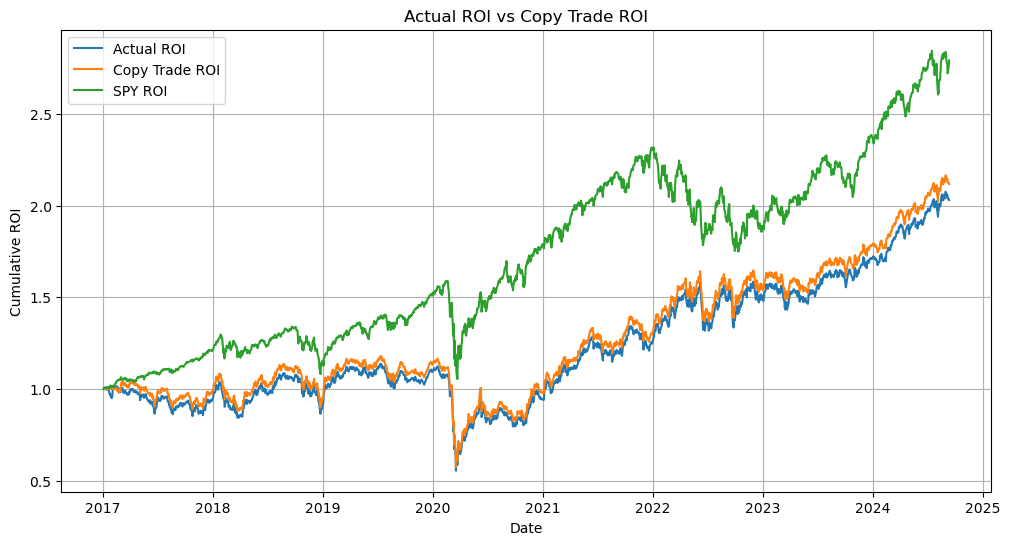

In [99]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio_roi['Date'], portfolio_roi['CumulativeROI'], label='Actual ROI')
plt.plot(portfolio_roi['Date'], portfolio_roi['CopyCumulativeROI'], label='Copy Trade ROI')
plt.plot(portfolio_roi['Date'], portfolio_roi['SPYCumROI'], label='SPY ROI')
plt.xlabel('Date')
plt.ylabel('Cumulative ROI')
plt.title('Actual ROI vs Copy Trade ROI')
plt.legend()
plt.grid(True)
plt.show()